In [1]:
import warnings 
warnings.filterwarnings('ignore')
import time 
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn import linear_model
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.svm import SVR
from mlxtend.regressor import StackingRegressor

In [2]:
def get_score(model, X, y_true):
    y_pred = model.predict(X)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_precision_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Data gathering 

In [3]:
data      = pd.read_csv('/Users/mohsenkiskani/.kaggle/competitions/ubaar-competition/train.csv')
test_data = pd.read_csv('/Users/mohsenkiskani/.kaggle/competitions/ubaar-competition/test.csv')

data      = data.dropna(axis = 0)

test_data.loc[12577, 'distanceKM']      = 52
test_data.loc[12577, 'taxiDurationMin'] = 50
test_data.loc[13853, 'distanceKM']      = 500
test_data.loc[13853, 'taxiDurationMin'] = 380

all_data = pd.concat((data, test_data)) 
all_data['source']           = all_data['sourceLatitude']*all_data['sourceLongitude']
all_data['destination']      = all_data['destinationLatitude']*all_data['destinationLongitude']

min_price = min(all_data['price'])

ntrain = data.shape[0]
ntest  = test_data.shape[0]

categorical_vars = ['date', 'SourceState', 'destinationState', 'vehicleType', 'vehicleOption']

dummies_data = pd.get_dummies(all_data[categorical_vars])
all_data[dummies_data.columns] = dummies_data[dummies_data.columns]
all_data.drop(categorical_vars, axis=1, inplace=True)

train    = all_data[:ntrain]
test     = all_data[ntrain:]

X = train.drop(['ID','price'],axis=1)
y = train.price

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,destinationLatitude,destinationLongitude,distanceKM,sourceLatitude,sourceLongitude,taxiDurationMin,weight,source,destination,SourceState_آذربایجان شرقی,...,vehicleType_treili,vehicleOption_bari,vehicleOption_hichkodam,vehicleOption_kafi,vehicleOption_kompressi,vehicleOption_labehdar,vehicleOption_mosaghaf_chadori,vehicleOption_mosaghaf_felezi,vehicleOption_transit_chadori,vehicleOption_yakhchali
39085,36.473089,52.349822,184.0,35.700109,51.399743,199.0,21.00,1834.976428,1909.359717,0,...,1,0,0,1,0,0,0,0,0,0
30892,35.704176,51.400280,331.0,37.275731,49.584392,254.0,1.67,1848.294458,1835.204644,0,...,0,0,0,0,0,0,1,0,0,0
45277,35.699924,51.396715,447.0,32.665899,51.663805,285.0,19.00,1687.644636,1834.858819,0,...,1,0,0,0,0,0,0,0,1,0
16398,30.199563,53.182966,809.0,35.699078,51.401589,525.0,4.00,1834.989335,1606.102332,0,...,0,0,0,0,0,0,1,0,0,0
13653,27.180941,56.277756,1144.0,34.643252,50.877469,750.0,2.00,1762.560980,1529.682365,0,...,0,0,0,0,0,0,1,0,0,0


# Initial Modelling

In [4]:
LGBF = lgb.LGBMRegressor(objective='regression',num_leaves=15,
                          learning_rate=0.05, n_estimators=15000,
                          max_bin = 1000, bagging_fraction = 0.6,
                          bagging_freq = 5, feature_fraction = 0.25,
                          feature_fraction_seed=9, bagging_seed=20,
                          min_data_in_leaf = 11, min_sum_hessian_in_leaf = 11)

GBSTF = GradientBoostingRegressor(n_estimators=3200, learning_rate=0.05,
                                  max_depth=10, max_features='sqrt',
                                  min_samples_leaf=15, min_samples_split=10, 
                                  loss='huber', random_state =5)

XGBF = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                        learning_rate=0.05, max_depth=10, 
                        min_child_weight=1.7817, n_estimators=2200,
                        reg_alpha=0.4640, reg_lambda=0.8571,
                        subsample=0.5213, silent=1,
                        random_state =5 , nthread = -1)

BAGF  = BaggingRegressor(n_estimators=100, max_samples=1.0, max_features=1.0, random_state=5, verbose=1)
DECF  = DecisionTreeRegressor(max_depth=15)
RFSTF = RandomForestRegressor(n_estimators=20, criterion='mae', 
                              max_depth=4, max_features='sqrt',
                              min_samples_leaf=5, min_samples_split =3, random_state = 42)

KNNF  = KNeighborsClassifier(2)
LASSF = Lasso(fit_intercept = True)
ABSTF = AdaBoostRegressor(n_estimators=1000, learning_rate=0.05, loss='linear', random_state=5)

SVRF = SVR()
RDGF = Ridge()
ENTF = make_pipeline(RobustScaler(), ElasticNet(alpha=0.8, l1_ratio=.9, random_state=3))

models = { "Gboost": GBSTF, "xgb": XGBF, "bagging": BAGF, "lgbm": LGBF, "dec_tree": DECF, "Random_forest": RFSTF,
          "knn": KNNF, "elasticNet": ENTF, "ridge": RDGF, "lasso": LASSF, "AdaBoost": ABSTF, "SVR": SVRF}

for model_name in models:
    model = models[model_name]
    start_time = time.time()
    model.fit(X_train, y_train)
    train_cols = X_train.columns.tolist()
    X_val['y_' + model_name] = model.predict(X_val[train_cols])
    score = mean_absolute_precision_error(X_val['y_' + model_name], y_val)
    print(model_name, '%.2f' % float((time.time() - start_time)/60 ) +" mins, score= ", '%.2f' % score)

X_val.to_pickle('dataFrames/One_Hot_X_val.pkl')

#Gboost        5.05 mins, score=  16.90
#xgb           6.62 mins, score=  17.15
#bagging       0.89 mins, score=  17.65
#lgbm          1.13 mins, score=  18.60
#dec_tree      0.01 mins, score=  21.83
#Random_forest 6.01 mins, score=  32.82
#knn           0.02 mins, score=  38.16
#elasticNet    0.01 mins, score=  83.91
#ridge         0.00 mins, score=  169.28
#lasso         0.10 mins, score=  146.42
#AdaBoost      1.29 mins, score=  30.73
#SVR           3.07 mins, score=  73.94
# KernelRidge and LinearRegression() take more than 1 hour to run! Don't Run them. 

Gboost 5.05 mins, score=  16.90
xgb 6.62 mins, score=  17.15


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


bagging 0.89 mins, score=  17.65
lgbm 1.13 mins, score=  18.60
dec_tree 0.01 mins, score=  21.83
Random_forest 6.01 mins, score=  32.82
knn 0.02 mins, score=  38.16
elasticNet 0.01 mins, score=  83.91
ridge 0.00 mins, score=  169.28
lasso 0.10 mins, score=  146.42
AdaBoost 1.29 mins, score=  30.73
SVR 3.07 mins, score=  73.94


# Plotting predictions

In [5]:
X_val = pd.read_pickle('dataFrames/One_Hot_X_val.pkl')
X_val.head()

,destinationLatitude,destinationLongitude,distanceKM,sourceLatitude,sourceLongitude,taxiDurationMin,weight,source,destination,SourceState_آذربایجان شرقی,...,y_bagging,y_lgbm,y_dec_tree,y_Random_forest,y_knn,y_elasticNet,y_ridge,y_lasso,y_AdaBoost,y_SVR
33553,36.471723,52.871692,1408.0,27.181578,56.278461,995.0,2.0,1529.737377,1928.321705,0,...,10249980.0,8.992700e+06,1.385000e+07,9963050.0,27550000.0,1.229336e+07,1.613474e+07,1.609353e+07,9.217693e+06,4.319977e+06
9427,29.611462,52.532224,1133.0,35.021640,58.786047,779.0,10.0,2058.783775,1555.555955,0,...,8525330.0,9.804477e+06,8.723114e+06,5850575.0,4085000.0,8.369962e+06,8.811189e+06,8.656820e+06,1.043168e+07,4.319978e+06
199,32.676185,51.671182,673.0,37.193824,50.150938,488.0,3.0,1865.305161,1688.417102,0,...,3396100.0,3.058116e+06,4.557882e+06,4500975.0,3200000.0,3.657013e+06,3.791612e+06,3.878740e+06,4.921228e+06,4.319974e+06
12447,37.393011,46.238081,1062.0,32.252484,54.010156,712.0,15.0,1741.961692,1728.981071,0,...,11805580.0,1.085989e+07,9.000000e+06,7274800.0,10700000.0,1.038843e+07,1.051309e+07,1.059327e+07,1.119553e+07,4.319977e+06
45079,30.403944,56.000462,251.0,31.881874,54.359440,167.0,15.0,1733.080817,1702.634911,0,...,3703470.0,4.275961e+06,3.067294e+06,4155200.0,2400000.0,4.572902e+06,4.865459e+06,4.881291e+06,3.781656e+06,4.319977e+06


In [6]:
pred_cols = ['y_Gboost', 'y_xgb', 'y_bagging', 'y_lgbm', 'y_dec_tree', 'y_Random_forest', 'y_knn',
             'y_elasticNet', 'y_ridge', 'y_lasso', 'y_AdaBoost', 'y_SVR']

best_cols = ['y_Gboost', 'y_xgb', 'y_bagging', 'y_lgbm']
best_pred = X_val[list(best_cols)]
best_pred.head()

,y_Gboost,y_xgb,y_bagging,y_lgbm
33553,9.719302e+06,9631332.00,10249980.0,8.992700e+06
9427,9.184199e+06,9451382.00,8525330.0,9.804477e+06
199,3.174649e+06,2934836.25,3396100.0,3.058116e+06
12447,1.101938e+07,10770556.00,11805580.0,1.085989e+07
45079,4.103860e+06,4209962.00,3703470.0,4.275961e+06


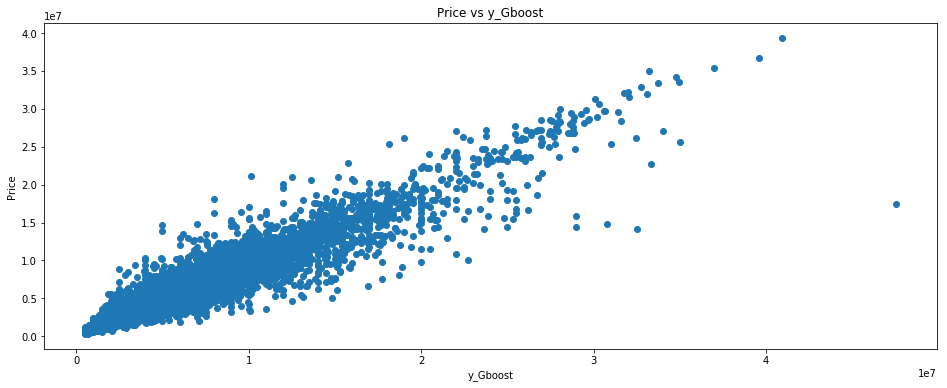

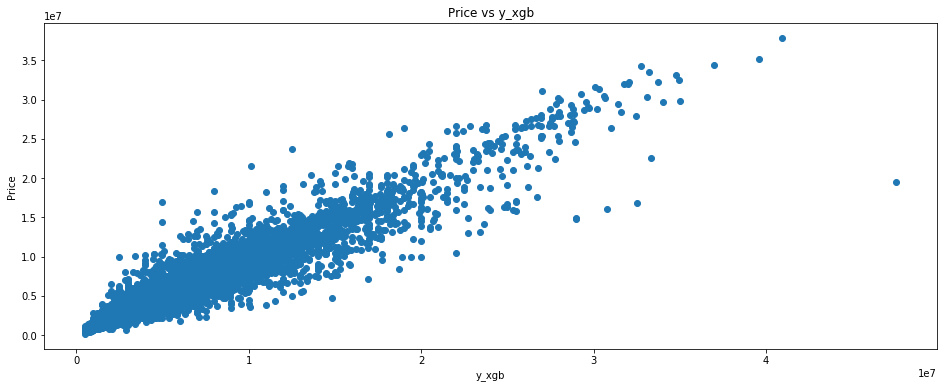

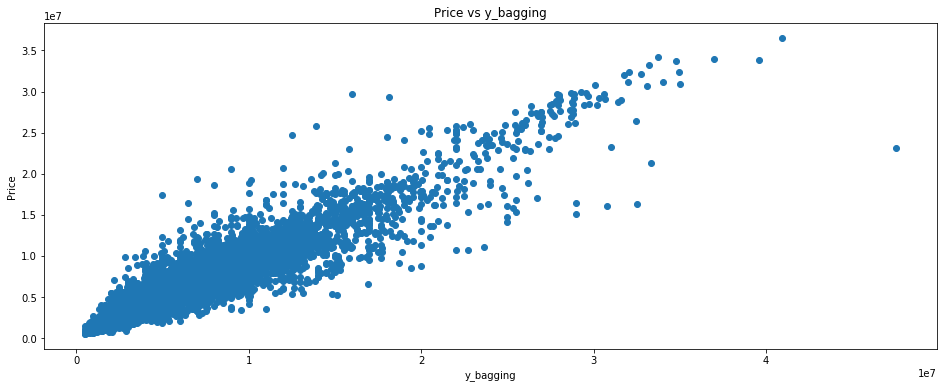

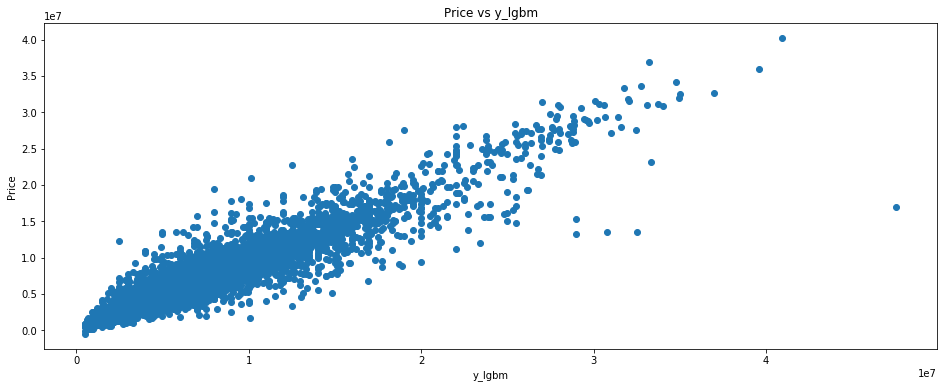

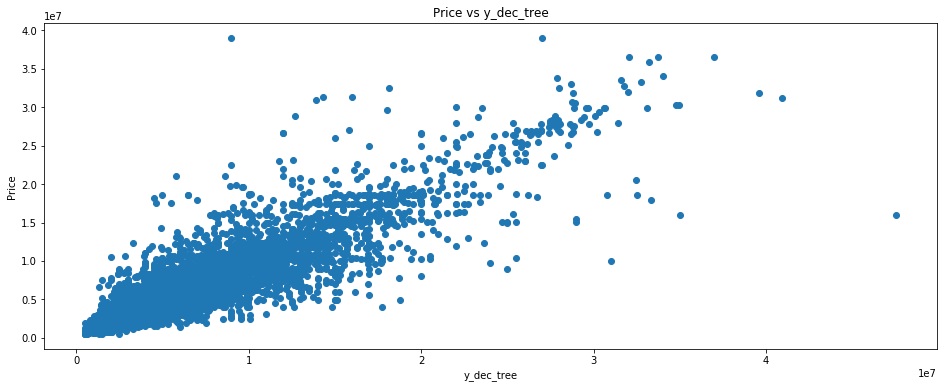

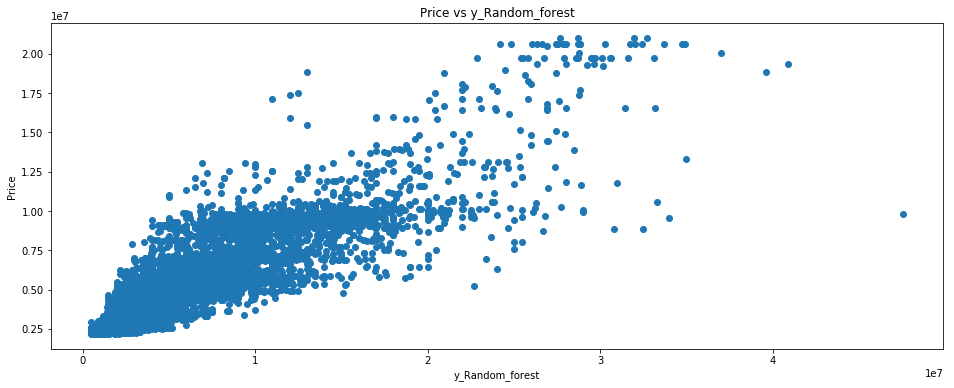

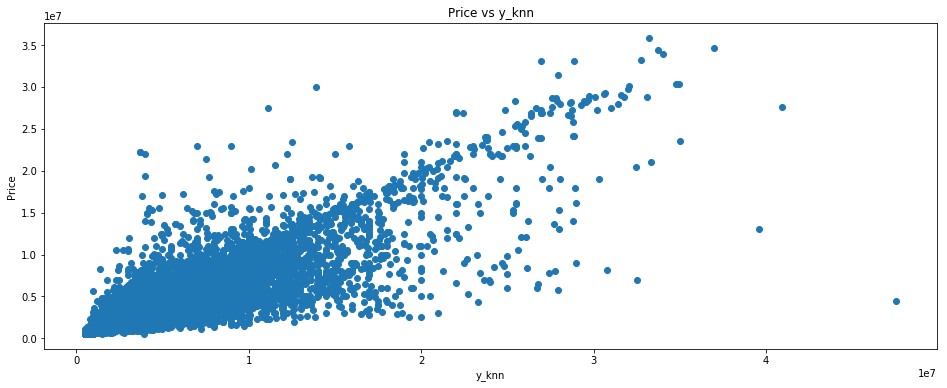

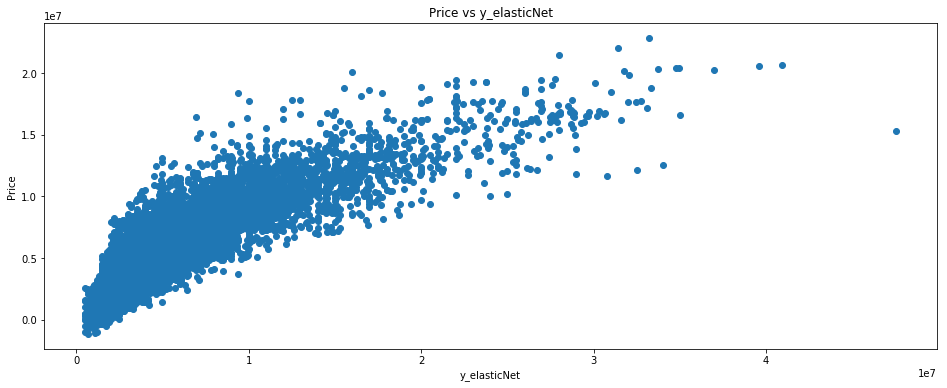

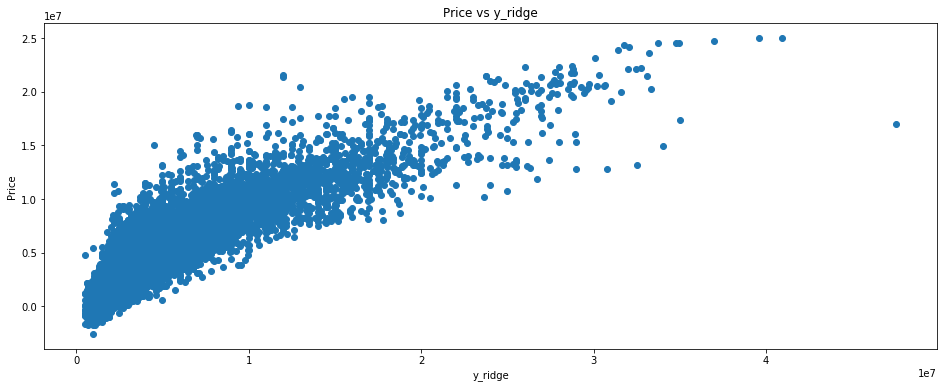

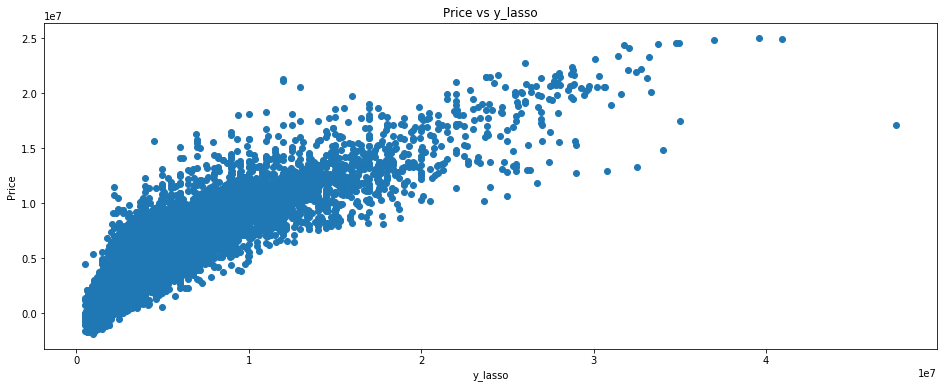

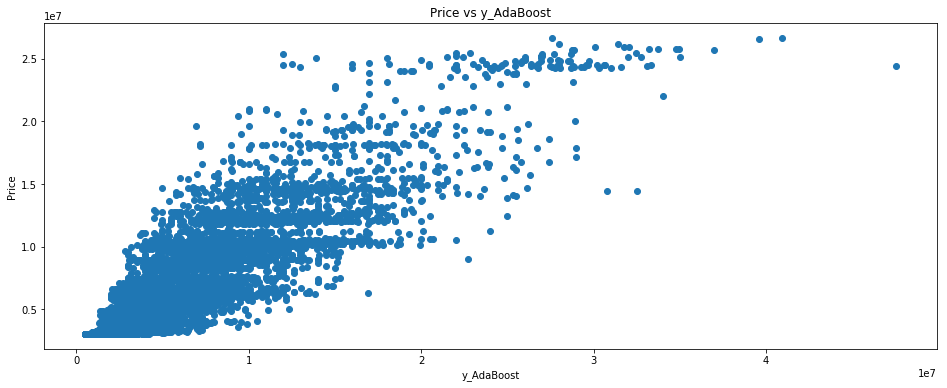

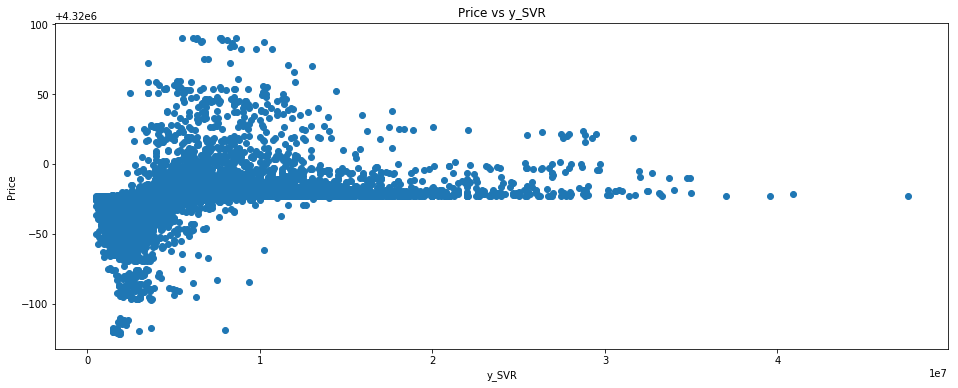

In [7]:
for col in pred_cols:
    plt.figure(figsize=(16,6))
    plt.scatter(y_val, X_val[col])
    plt.title('Price vs '+ col)
    plt.xlabel(col)
    plt.ylabel('Price')
    plt.show()

# Stacking 

In [8]:
regressors = [XGBF, BAGF, LGBF]
stregr     = StackingRegressor(regressors=regressors, meta_regressor=GBSTF)
start_time = time.time()
stregr.fit(X_train, y_train)
y_pred = stregr.predict(X_val[train_cols])
score  = mean_absolute_precision_error(y_pred, y_val)
print("stackingRegressor model", '%.2f' % float((time.time() - start_time)/60 ) +" mins, score= ", '%.2f' % score)
# stackingRegressor model 10.60 mins, score=  17.40

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


stackingRegressor model 10.60 mins, score=  17.40


In [9]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                #instance.fit(X[train_index], y[train_index])
                instance.fit(X.iloc[train_index], y.iloc[train_index])
                y_pred = instance.predict(X.iloc[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [ ]:
start_time = time.time() 
stacked_averaged_models  = StackingAveragedModels(base_models = (XGBF, BAGF), meta_model = GBSTF)
stacked_averaged_models.fit(X_train, y_train)
y_pred = stacked_averaged_models.predict(X_val[train_cols])
score  = mean_absolute_precision_error(y_pred, y_val)
print("stacking Averaged models", '%.2f' % float((time.time() - start_time)/60 ) +" mins, score =", '%.2f' % score)

# Final model

In [ ]:
# Current best model 
start_time = time.time()
GBST = GradientBoostingRegressor(n_estimators=3200, learning_rate=0.05,
                                  max_depth=10, max_features='sqrt',
                                  min_samples_leaf=15, min_samples_split=10, 
                                  loss='huber', random_state =5)

GBST.fit(train.drop(['ID','price'],axis=1), train.price)
y_pred_test = GBST.predict(test.drop(['ID','price'],axis=1))

print('%.2f' % float((time.time() - start_time)/60 ) +" mins.")

# Save to file

In [ ]:
filename = "/Users/mohsenkiskani/Downloads/Ubaar/submissions/submission32.csv"
with open(filename,"w+") as outputfile:
    outputfile.write("ID,price\n")
    for i in range(y_pred_test.shape[0]):
        outputfile.write(str(test_data.ID[i])+","+str(int(np.ceil(y_pred_test[i])))+"\n")